In [1]:
import cv2 
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

## Keypoints Using MP holistic 

In [2]:
mp_holistic=mp.solutions.holistic
mp_drawing=mp.solutions.drawing_utils

In [3]:
def mediapipe_detection(image,model):
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
#     image is not writeable
    image.flags.writeable=False
#     making prediction
    results=model.process(image)
    image.flags.writeable=True
    image=cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    return image,results

In [4]:
def draw_styled_landmark(image,result):
    mp_drawing.draw_landmarks(image,result.face_landmarks,mp_holistic.FACE_CONNECTIONS,mp_drawing.DrawingSpec(color=(80,110,10),thickness=1,circle_radius=1),mp_drawing.DrawingSpec(color=(80,256,121),thickness=1,circle_radius=1))
    mp_drawing.draw_landmarks(image,result.pose_landmarks,mp_holistic.POSE_CONNECTIONS,mp_drawing.DrawingSpec(color=(80,22,10),thickness=2,circle_radius=4),mp_drawing.DrawingSpec(color=(80,44,121),thickness=2,circle_radius=4))
    mp_drawing.draw_landmarks(image,result.left_hand_landmarks,mp_holistic.HAND_CONNECTIONS,mp_drawing.DrawingSpec(color=(121,22,76),thickness=2,circle_radius=4),mp_drawing.DrawingSpec(color=(232,44,250),thickness=2,circle_radius=2))
    mp_drawing.draw_landmarks(image,result.right_hand_landmarks,mp_holistic.HAND_CONNECTIONS,mp_drawing.DrawingSpec(color=(245,117,66),thickness=2,circle_radius=4),mp_drawing.DrawingSpec(color=(245,66,230),thickness=2,circle_radius=2))
       

In [5]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
    #     read feed
        ret,frame=cap.read()
        image,results=mediapipe_detection(frame,holistic)
    #     share to screen 
#     DRAW LANDMARKS
        draw_styled_landmark(image,results)
        cv2.imshow('opencv',image)
        if cv2.waitKey(10) & 0xFF==ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()
        
    

In [31]:
draw_styled_landmark(image,results)

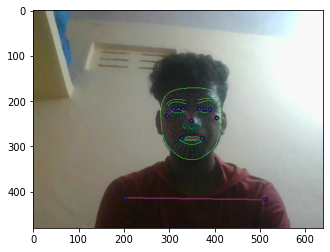

In [32]:
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

## Extract Keypoint Values

In [5]:
def extract_keypoints(results):
    pose=np.array([[res.x,res.y,res.z,res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
    lh=np.array([[res.x,res.y,res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh=np.array([[res.x,res.y,res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    face=np.array([[res.x,res.y,res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
    
    return np.concatenate([pose,face,lh,rh])

In [6]:
Data_Path=os.path.join('MP_Data')
actions=np.array(['hello','thanks','iloveyou'])
no_sequences=30
sequence_length=30
start_folder=30

In [ ]:
# for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(Data_Path, action, str(sequence)))
        except:
            pass

##  Collect Keypoint Values for Training and Testing

In [36]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
    for action in actions:
        for sequence in range(no_sequences):
            for frame_num in range(sequence_length):
                
            #     read feed
                ret,frame=cap.read()
                image,results=mediapipe_detection(frame,holistic)
            #     share to screen 
        #     DRAW LANDMARKS
                draw_styled_landmark(image,results)
                if frame_num==0:
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                keypoints=extract_keypoints(results)
                npy_path=os.path.join(Data_Path,action,str(sequence),str(frame_num))
                np.save(npy_path,keypoints)
                
#                 cv2.imshow('opencv',image)
                if cv2.waitKey(10) & 0xFF==ord('q'):
                    break
    cap.release()
    cv2.destroyAllWindows()
        
    

## Preprocess Data and Create Labels and Features

In [7]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [8]:
label_map={label:num for num,label in enumerate(actions)}

In [9]:
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [10]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(Data_Path, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [11]:
X=np.array(sequences)

In [12]:
y=to_categorical(labels).astype(int)

In [13]:
y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

In [14]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.06)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense
from tensorflow.keras.callbacks import TensorBoard

In [16]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [18]:
pip install numpy==1.19.5

Note: you may need to restart the kernel to use updated packages.


In [17]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [21]:
res=[0.7,0.2,0.1]

'hello'

In [22]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [106]:
model.fit(X_train, y_train, epochs=200, callbacks=[tb_callback])

Epoch 1/200
3/3 [==============================] - 6s 483ms/step - loss: 3.6055 - categorical_accuracy: 0.3659
Epoch 2/200
3/3 [==============================] - 0s 88ms/step - loss: 15.2086 - categorical_accuracy: 0.1758
Epoch 3/200
3/3 [==============================] - 0s 87ms/step - loss: 15.3616 - categorical_accuracy: 0.2638
Epoch 4/200
3/3 [==============================] - 0s 86ms/step - loss: 14.5923 - categorical_accuracy: 0.3108
Epoch 5/200
3/3 [==============================] - 0s 87ms/step - loss: 10.8725 - categorical_accuracy: 0.3307
Epoch 6/200
3/3 [==============================] - 0s 88ms/step - loss: 5.1649 - categorical_accuracy: 0.3659
Epoch 7/200
3/3 [==============================] - 0s 85ms/step - loss: 4.1105 - categorical_accuracy: 0.3480
Epoch 8/200
3/3 [==============================] - 0s 86ms/step - loss: 21.2339 - categorical_accuracy: 0.3095
Epoch 9/200
3/3 [==============================] - 0s 89ms/step - loss: 30.7816 - categorical_accuracy: 0.4036
Epo

3/3 [==============================] - 0s 87ms/step - loss: 1.1413 - categorical_accuracy: 0.6676
Epoch 148/200
3/3 [==============================] - 0s 87ms/step - loss: 0.8602 - categorical_accuracy: 0.6477
Epoch 149/200
3/3 [==============================] - 0s 86ms/step - loss: 0.8830 - categorical_accuracy: 0.6594
Epoch 150/200
3/3 [==============================] - 0s 86ms/step - loss: 1.0886 - categorical_accuracy: 0.6672
Epoch 151/200
3/3 [==============================] - 0s 87ms/step - loss: 0.7079 - categorical_accuracy: 0.6773
Epoch 152/200
3/3 [==============================] - 0s 85ms/step - loss: 0.8310 - categorical_accuracy: 0.5476
Epoch 153/200
3/3 [==============================] - 0s 86ms/step - loss: 0.7746 - categorical_accuracy: 0.6966
Epoch 154/200
3/3 [==============================] - 0s 86ms/step - loss: 0.7675 - categorical_accuracy: 0.7321
Epoch 155/200
3/3 [==============================] - 0s 86ms/step - loss: 0.7642 - categorical_accuracy: 0.6654
Epoch 

In [49]:
model.load_weights('weights.h5')

In [38]:
res=model.predict(X_test)
print(X_test.shape)


(6, 30, 1662)


In [39]:
actions[np.argmax(res[5])]

'iloveyou'

In [40]:
actions[np.argmax(y_test[5])]

'iloveyou'

## Save Weights

In [83]:
model.save('weights.h5')

## Evaluation using Confusion Matrix and Accuracy

In [41]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [42]:
yhat=model.predict(X_test)


In [43]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [44]:

multilabel_confusion_matrix(ytrue, yhat)

array([[[2, 1],
        [0, 3]],

       [[5, 0],
        [0, 1]],

       [[4, 0],
        [1, 1]]])

In [45]:
accuracy_score(ytrue, yhat)

0.8333333333333334

In [46]:
x1=np.array([1,2,3,4])
print(x1[:3])

[1 2 3]


In [51]:
sequence=[]
threshold=0.7
sentence=[]
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
    #     read feed
        ret,frame=cap.read()
        image,results=mediapipe_detection(frame,holistic)
    #     share to screen 
#     DRAW LANDMARKS
        draw_styled_landmark(image,results)
        keypoints=extract_keypoints(results)
        sequence.append(keypoints)
#         if len(sequence)>=30:
        x_train=sequence[-30:]
        res=model.predict(np.expand_dims(x_train,axis=0))
        res=res[0]
        if res[np.argmax(res)]>threshold:
            if len(sentence)>0:
                if(actions[np.argmax(res)]!=sentence[-1]):
                    sentence.append(actions[np.argmax(res)])
            else:
                sentence.append(actions[np.argmax(res)])
        if len(sentence)>5:
            sentence=sentence[-5:]
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
            
        cv2.imshow('opencv',image)
        if cv2.waitKey(10) & 0xFF==ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()
        
    